In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import *
import matplotlib.pyplot as plt

In [2]:
import scipy.io
mat = scipy.io.loadmat('../DATA/CYLINDER_ALL.mat',)
nx = 449
ny = 199
dt = .2

In [3]:
xx, yy = np.meshgrid(np.linspace(-1, 8, nx), np.linspace(-2, 2, ny))

def cylinder_clean_data(X, fill = 0):
    
    uu = X.reshape((ny, nx, -1), order = 'F')
    uu[(xx**2+yy**2)<.5**2, :] = fill
    
    return uu.reshape((ny*nx, -1), order = 'F')

def reshaping(X):
    
    return X.reshape((ny, nx), order = 'F')

cylinder_idx = (xx**2+yy**2)<.5**2

## X Velocity reduction

In [4]:
X = cylinder_clean_data(mat["UALL"])

In [5]:
model = POD()
pod = ROM(model)
pod.decompose(X, alg = "snap")

## CPU Time (SVD vs Snapshot)

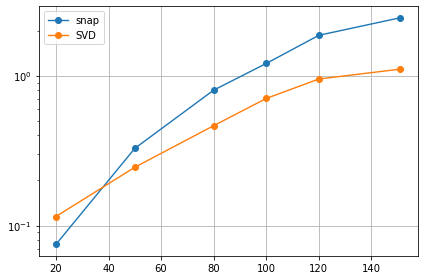

In [6]:
import time
cov_times = []
svd_times = []
sizes = [20, 50, 80, 100, 120, 151]
nt = 5

for s in  sizes:
    t0 = time.time()
    for _ in range (nt):
        model = POD()
        pod = ROM(model)
        pod.decompose(X[:, :s], alg = "snap")
    t1 = time.time()
    cov_times.append((t1 - t0)/nt)

    t0 = time.time()
    for _ in range (nt):
        model = POD()
        pod = ROM(model)
        pod.decompose(X[:, :s], alg = "svd")
    t1 = time.time()
    svd_times.append((t1 - t0)/nt)

plt.semilogy(sizes, cov_times, "o-", label = "snap", linewidth = 1.4);
plt.semilogy(sizes, svd_times, "o-", label = "SVD", linewidth = 1.4);
plt.grid();
plt.legend();
plt.tight_layout();

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

DMD reduction on X components velocity

In [45]:
## Parameters ----------------
rank = 0
dt = .2
X = np.nan_to_num(cylinder_clean_data(mat["UALL"]), 0) # X-Velocity
t = np.linspace(0, (X.shape[1]-1) * dt, X.shape[1])

In [46]:
modeld = DMD()
dmd = ROM(modeld)
dmd.decompose(X[:, :-1], Y = X[:, 1::], dt = dt, rank = rank)

## Fastest way to compute DMD mode amplitudes
Reconstruct data using dmd on the first 151 instants

In [48]:
import time

t0 = time.time()
for _ in range(40):
    s, _, _, _ = np.linalg.lstsq(dmd.model.dmd_modes, X[:, 0], rcond=None)
t1 = time.time()
print("Least square ", .025 * (t1 - t0), " s")

t0 = time.time()
for _ in range(40):
    s_ = np.linalg.pinv((dmd.model.dmd_modes)) @ X[:, 0]
t1 = time.time()
print("Pseudo inverse ", .025 * (t1 - t0), " s")
print("Difference", np.linalg.norm(s-s_)/np.linalg.norm(s))


lambd, w = np.linalg.eig(dmd.model.A_tilde)
idx = np.abs(lambd).argsort()[::-1]
lambd = lambd[idx]
w = w[:, idx]
t0 = time.time()
for _ in range(40):
    alpha1 = dmd.singvals * dmd.time[:, 0]
    s_schmidt = np.linalg.solve(w, alpha1)
t1 = time.time()
print("schmidt ", .025 * (t1 - t0), " s")
print("Difference", np.linalg.norm(s_schmidt-s_)/np.linalg.norm(s_))


t0 = time.time()
for _ in range(40):
    alpha1 = dmd.singvals * dmd.time[:, 0]
    s_tu = np.linalg.solve((dmd.model.A_tilde @ w), alpha1)
t1 = time.time()
print("tu et al. 1 ", .025 * (t1 - t0), " s")
print("Difference", np.linalg.norm(s_-s_tu)/np.linalg.norm(s_))

t0 = time.time()
for _ in range(40):
    alpha1 = dmd.singvals * dmd.time[:, 0]
    s_tu2 = np.linalg.solve((lambd * w), alpha1)
t1 = time.time()
print("tu et al. 2 ", .025 * (t1 - t0), " s")
print("Difference", np.linalg.norm(s_-s_tu2)/np.linalg.norm(s_))

Least square  1.3717884004116059  s
Pseudo inverse  2.7625509679317477  s
Difference 4.185761352375712e-15
schmidt  0.0022054195404052736  s
Difference 0.0349402720143919
tu et al. 1  0.010702413320541383  s
Difference 3.0343670770615847e-05
tu et al. 2  0.002412831783294678  s
Difference 3.034367077065451e-05
